# Dataset Complexity Analysis

This notebook explores the Random Forest complexity metrics contained in ``forest_report.json``. It replicates the logic used by ``sort_datasets_by_complexity.py`` and enriches it with tabular views and visualisations to better understand how each dataset compares.

## Load the dataset report

The JSON report is generated by ``dataset_forest_report.py``. Each entry contains metadata about the dataset alongside summary statistics for the optimised Random Forest model.

In [18]:
from __future__ import annotations

from pathlib import Path
from typing import Any, Mapping
import json

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')
REPORT_PATH = Path('forest_report.json')
REPORT_PATH.resolve()

PosixPath('/Users/danielamadori/Projects/drifts/random_path_worker/icde/forest_report.json')

In [19]:
with REPORT_PATH.open('r', encoding='utf-8') as handle:
    report_data: list[dict[str, Any]] = json.load(handle)

len(report_data)

87

## Build a summary table

We reuse the Random Forest estimator counts reported in ``forest_report.json`` to build a sortable summary. This mirrors the CLI behaviour after switching to raw estimator counts.

In [20]:
def to_int(value: Any | None) -> int | None:
    try:
        return int(value)
    except (TypeError, ValueError):
        return None


def to_float(value: Any | None) -> float | None:
    try:
        return float(value)
    except (TypeError, ValueError):
        return None


def extract_metadata(entry: Mapping[str, Any]) -> dict[str, Any]:
    metadata = entry.get('metadata')
    if not isinstance(metadata, Mapping):
        metadata = {}

    statistics = entry.get('forest_statistics')
    if not isinstance(statistics, Mapping):
        statistics = {}

    dataset = str(entry.get('dataset', '')) or '<unknown>'

    return {
        'dataset': dataset,
        'n_estimators': to_int(statistics.get('n_estimators')),
        'series_length': to_int(metadata.get('series_length')),
        'train_size': to_int(metadata.get('train_size')),
        'test_size': to_int(metadata.get('test_size')),
        'avg_depth': to_float(statistics.get('avg_depth')),
        'avg_leaves': to_float(statistics.get('avg_leaves')),
        'avg_nodes': to_float(statistics.get('avg_nodes')),
    }


# Build summary dataframe from forest_report.json
summary_rows = [extract_metadata(entry) for entry in report_data]
summary_df = pd.DataFrame(summary_rows)

# Load EU data from eu_data.json
eu_data_path = Path('eu_data.json')
eu_metrics = {}  # {dataset: {'n_features': X, 'mean_eu': Y, 'eu_complexity': Z}}

if eu_data_path.exists():
    print(f"Loading EU data from {eu_data_path}...")
    try:
        with eu_data_path.open('r', encoding='utf-8') as f:
            eu_data_dict = json.load(f)
        
        # Process each dataset's EU data
        for dataset_name, features_dict in eu_data_dict.items():
            if isinstance(features_dict, dict):
                lengths = []
                for feature_name, endpoints in features_dict.items():
                    if isinstance(endpoints, (list, np.ndarray)):
                        lengths.append(len(endpoints))
                
                if lengths:
                    n_features = len(lengths)
                    mean_eu = np.mean(lengths)
                    eu_complexity = mean_eu * n_features
                    
                    eu_metrics[dataset_name] = {
                        'n_features': n_features,
                        'mean_eu': mean_eu,
                        'eu_complexity': eu_complexity
                    }
        
        print(f"✓ Loaded EU metrics for {len(eu_metrics)} datasets")
    
    except Exception as e:
        print(f"⚠ Error loading EU data: {e}")
else:
    print(f"⚠ {eu_data_path} not found. EU metrics will be N/A.")
    print("  Run: python extract_eu_from_redis.py --output eu_data.json --summary")

# Add EU metrics columns to summary_df
summary_df['n_features'] = summary_df['dataset'].apply(
    lambda d: eu_metrics[d]['n_features'] if d in eu_metrics else None
)
summary_df['mean_eu'] = summary_df['dataset'].apply(
    lambda d: eu_metrics[d]['mean_eu'] if d in eu_metrics else None
)
summary_df['eu_complexity'] = summary_df['dataset'].apply(
    lambda d: eu_metrics[d]['eu_complexity'] if d in eu_metrics else None
)

# Reorder columns for better logical flow:
# 1. Dataset name
# 2. EU Metrics (n_features, mean_eu, eu_complexity)
# 3. Forest Metrics (n_estimators, avg_depth, avg_leaves, avg_nodes)
# 4. Dataset Size (series_length, train_size, test_size)
summary_df = summary_df[[
    'dataset',
    'n_features', 'mean_eu', 'eu_complexity',
    'n_estimators', 'avg_depth', 'avg_leaves', 'avg_nodes',
    'series_length', 'train_size', 'test_size'
]]

# Fill NaN values with infinity for sorting (will push missing values to end)
summary_df['_sort_n_estimators'] = summary_df['n_estimators'].fillna(float('inf'))
summary_df['_sort_eu_complexity'] = summary_df['eu_complexity'].fillna(float('inf'))
summary_df['_sort_series_length'] = summary_df['series_length'].fillna(float('inf'))

# Sort by: n_estimators (primary), eu_complexity (secondary), series_length (tertiary), dataset (quaternary)
summary_df = summary_df.sort_values(
    ['_sort_n_estimators', '_sort_eu_complexity', '_sort_series_length', 'dataset'],
    ascending=[True, True, True, True]
).drop(columns=['_sort_n_estimators', '_sort_eu_complexity', '_sort_series_length']).reset_index(drop=True)

print(f"\n{'='*80}")
print(f"DATASET SUMMARY")
print(f"{'='*80}")
print(f"Total datasets: {len(summary_df)}")
print(f"Datasets with EU data: {summary_df['eu_complexity'].notna().sum()}")
print(f"Datasets with forest data: {summary_df['n_estimators'].notna().sum()}")
print(f"\nSorted by: n_estimators → eu_complexity → series_length → dataset name")
print(f"{'='*80}\n")


Loading EU data from eu_data.json...
✓ Loaded EU metrics for 23 datasets

DATASET SUMMARY
Total datasets: 87
Datasets with EU data: 23
Datasets with forest data: 86

Sorted by: n_estimators → eu_complexity → series_length → dataset name



## Full dataset ranking

The full table mirrors the CLI output but includes additional metadata for reference. The `eu_complexity` column shows the product of mean EU length × number of features.

In [21]:
styled_summary = summary_df.style.format({
    'n_estimators': '{:,}'.format,
    'series_length': '{:,}'.format,
    'n_features': lambda x: f'{int(x):,}' if pd.notna(x) else 'N/A',
    'mean_eu': lambda x: f'{x:.2f}' if pd.notna(x) else 'N/A',
    'eu_complexity': lambda x: f'{x:,.0f}' if pd.notna(x) else 'N/A',
    'avg_depth': '{:.2f}'.format,
    'avg_leaves': '{:,.2f}'.format,
    'avg_nodes': '{:,.2f}'.format,
}).background_gradient(
    subset=['eu_complexity'], 
    cmap='RdYlGn_r', 
    axis=0
).set_properties(
    subset=['n_features', 'mean_eu', 'eu_complexity'],
    **{'background-color': '#f0f9ff', 'font-weight': 'bold'}
)
styled_summary

,dataset,n_features,mean_eu,eu_complexity,n_estimators,avg_depth,avg_leaves,avg_nodes,series_length,train_size,test_size
0,ChlorineConcentration,166,52.27,"8,676",10.0,15.10,39.40,77.80,166,467,3840
1,MelbournePedestrian,N/A,N/A,N/A,10.0,9.30,40.20,79.40,24,1138,2319
2,MiddlePhalanxOutlineCorrect,N/A,N/A,N/A,10.0,8.00,35.60,70.20,80,600,291
3,ElectricDevices,N/A,N/A,N/A,10.0,26.60,360.90,720.80,96,8926,7711
4,Wafer,N/A,N/A,N/A,10.0,6.80,13.20,25.40,152,1000,6164
5,Wine,N/A,N/A,N/A,10.0,2.60,4.40,7.80,234,57,54
6,FordA,N/A,N/A,N/A,10.0,10.30,30.00,59.00,500,3601,1320
7,FordB,N/A,N/A,N/A,10.0,12.20,30.00,59.00,500,3636,810
8,ScreenType,N/A,N/A,N/A,10.0,0.20,1.20,1.40,720,375,375
9,SonyAIBORobotSurface1,N/A,N/A,N/A,17.0,1.65,2.71,4.41,70,20,601


## Smallest datasets by estimator count

A horizontal bar chart provides a compact overview of the datasets with the smallest ensembles.

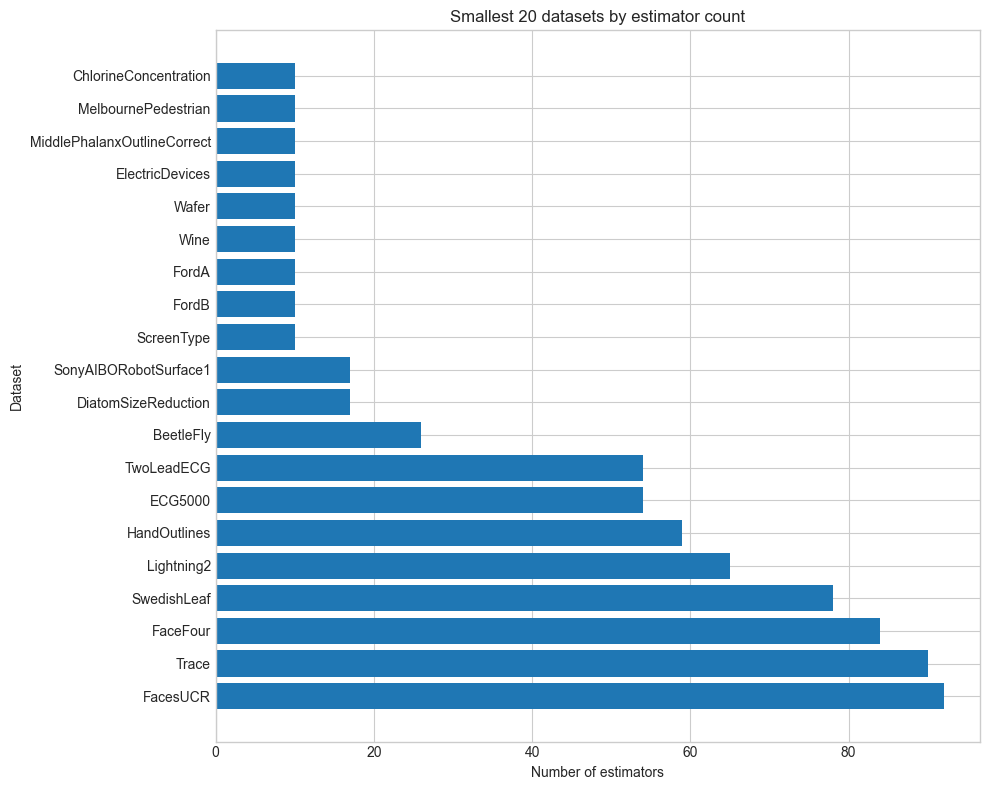

In [22]:
smallest_n = 20
least_complex = summary_df.head(smallest_n)
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(least_complex['dataset'], least_complex['n_estimators'], color='#1f77b4')
ax.set_xlabel('Number of estimators')
ax.set_ylabel('Dataset')
ax.set_title(f'Smallest {smallest_n} datasets by estimator count')
ax.invert_yaxis()
plt.tight_layout()
plt.show()


## Distribution of estimator counts

Finally, a histogram shows how estimator usage varies across datasets.

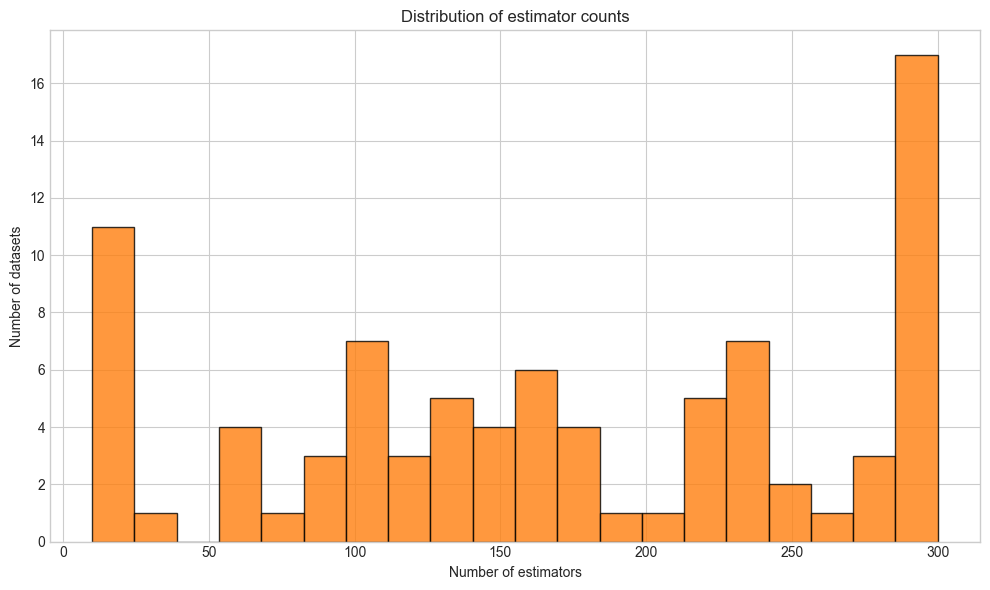

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(summary_df['n_estimators'], bins=20, color='#ff7f0e', edgecolor='black', alpha=0.8)
ax.set_xlabel('Number of estimators')
ax.set_ylabel('Number of datasets')
ax.set_title('Distribution of estimator counts')
plt.tight_layout()
plt.show()

## Endpoints Universe (EU) Analysis

Detailed analysis of EU statistics: vector lengths for each feature and calculation of average EU normalized by number of features.

In [24]:
# Load EU data for detailed statistics
eu_data_file = Path('eu_data.json')
eu_stats_rows = []

if eu_data_file.exists():
    print(f"Loading EU data from {eu_data_file}...")
    try:
        with eu_data_file.open('r', encoding='utf-8') as f:
            eu_data_from_redis = json.load(f)
        
        # Process EU data from Redis extraction
        for dataset, features_dict in eu_data_from_redis.items():
            if isinstance(features_dict, dict):
                lengths = []
                for feature_name, endpoints in features_dict.items():
                    if isinstance(endpoints, (list, np.ndarray)):
                        lengths.append(len(endpoints))
                
                if lengths:
                    n_features = len(lengths)
                    total_eu_length = sum(lengths)
                    
                    eu_stats_rows.append({
                        'dataset': dataset,
                        'n_features': n_features,
                        'min_length': min(lengths),
                        'max_length': max(lengths),
                        'mean_length': np.mean(lengths),
                        'std_length': np.std(lengths),
                        'total_eu_length': total_eu_length,
                        'avg_eu_per_feature': total_eu_length / n_features if n_features > 0 else 0
                    })
        
        print(f"✓ Loaded EU data for {len(eu_stats_rows)} datasets from Redis extraction")
    
    except Exception as e:
        print(f"Error loading EU data from {eu_data_file}: {e}")
        eu_stats_rows = []

if eu_stats_rows:
    eu_stats_df = pd.DataFrame(eu_stats_rows)
    eu_stats_df = eu_stats_df.sort_values('avg_eu_per_feature', ascending=True).reset_index(drop=True)
    print(f"\n✓ EU statistics available for {len(eu_stats_df)} datasets")
    eu_stats_df.head(10)
else:
    print("\nWARNING: No EU data found.")
    print("\nTo extract EU data from Redis, run:")
    print("  python extract_eu_from_redis.py --output eu_data.json --summary")
    eu_stats_df = None

Loading EU data from eu_data.json...
✓ Loaded EU data for 23 datasets from Redis extraction

✓ EU statistics available for 23 datasets


In [25]:
if eu_stats_df is not None and not eu_stats_df.empty:
    # Display EU statistics table
    styled_eu_stats = eu_stats_df.style.format({
        'n_features': '{:,}'.format,
        'min_length': '{:,}'.format,
        'max_length': '{:,}'.format,
        'mean_length': '{:.2f}'.format,
        'std_length': '{:.2f}'.format,
        'total_eu_length': '{:,}'.format,
        'avg_eu_per_feature': '{:.2f}'.format,
    })
    styled_eu_stats
else:
    print("No EU statistics available.")

### Complexity Score Visualizations

Visual representation of dataset complexity scores with comparative analysis.

/var/folders/6s/4jp9wfn12rg803s_754kv2rc0000gp/T/ipykernel_8368/284792377.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


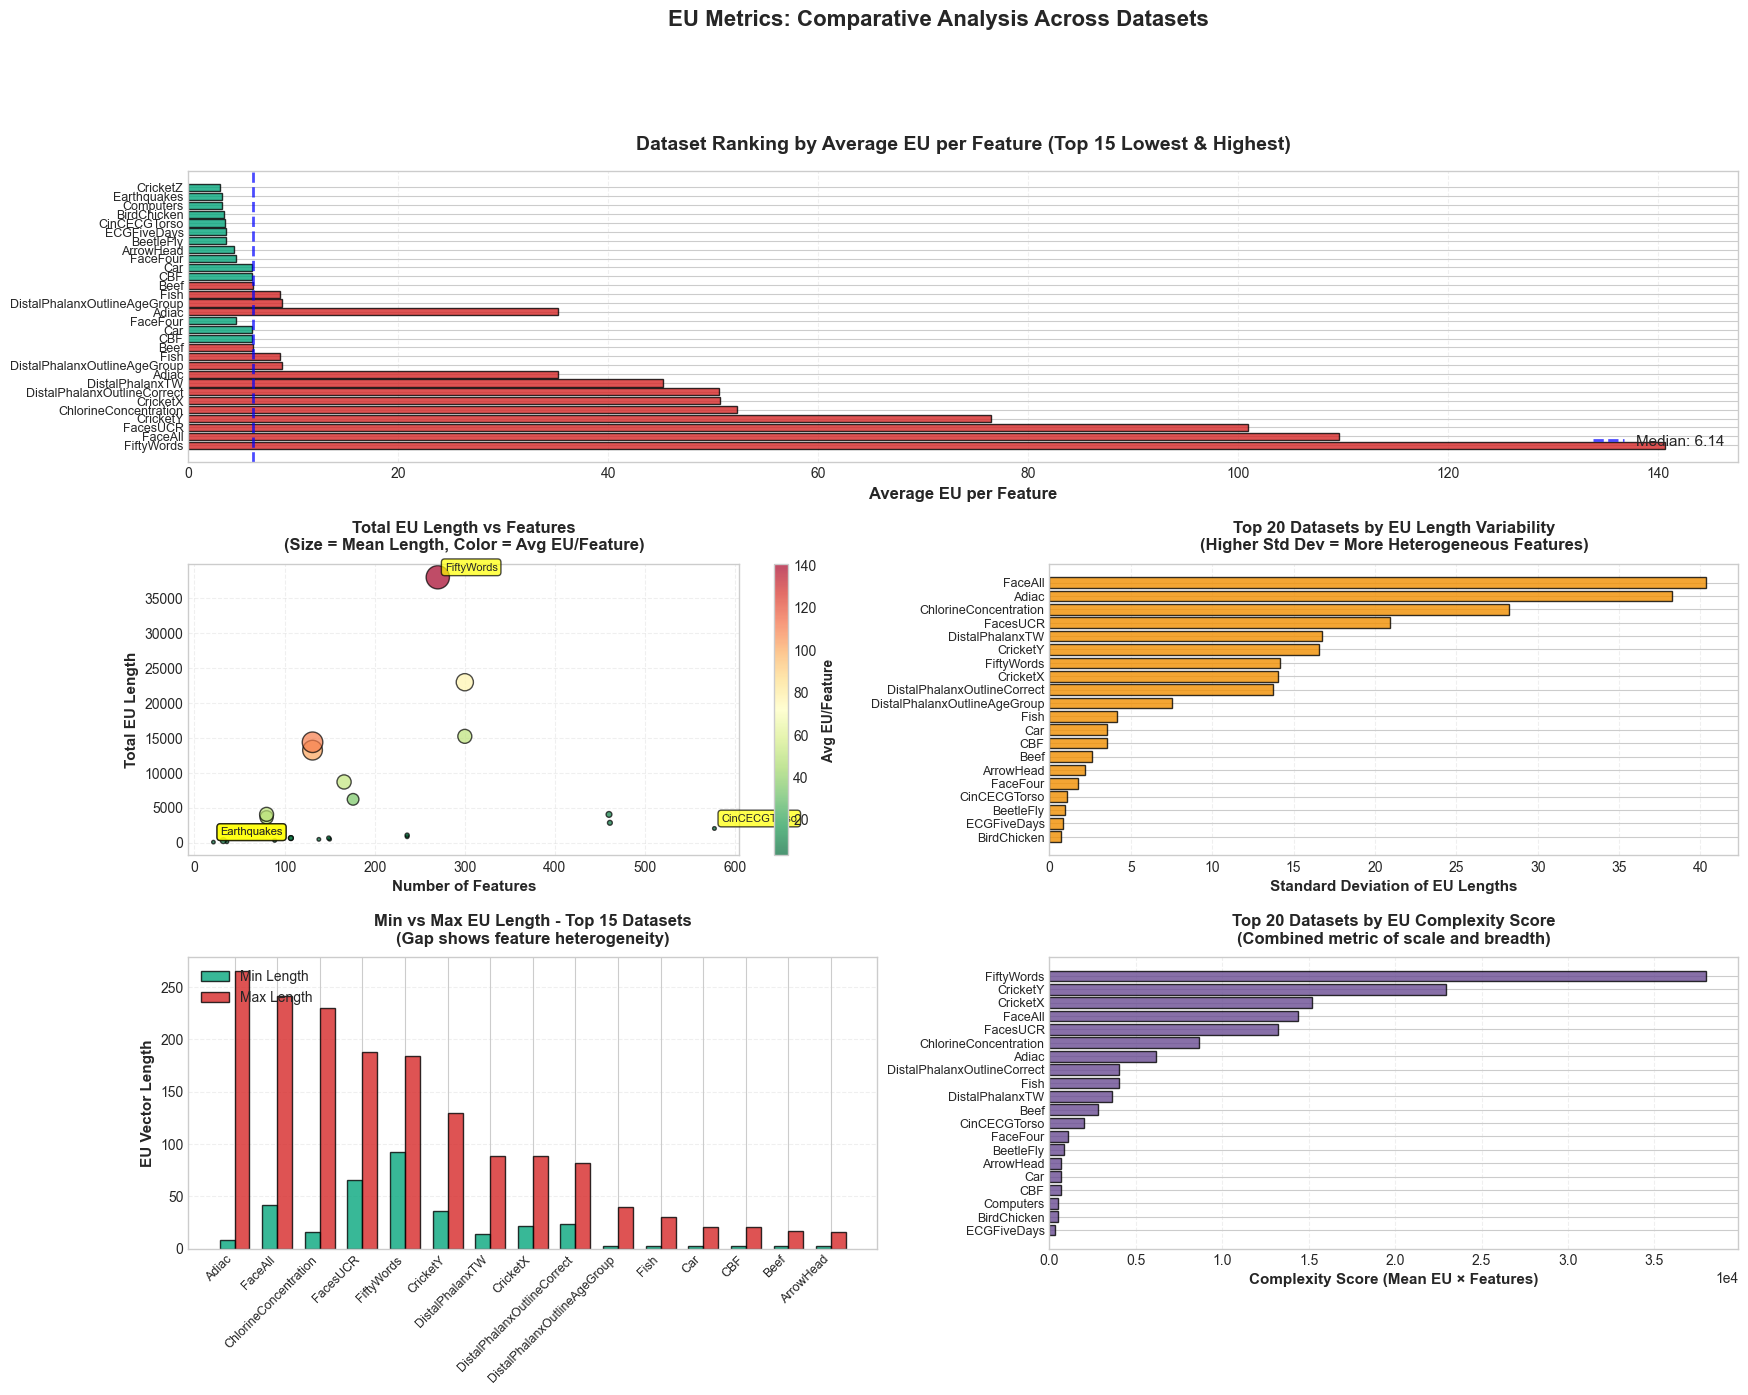


COMPARATIVE ANALYSIS INSIGHTS

1. AVERAGE EU PER FEATURE RANKING:
   - Lowest: CricketZ = 3.03
   - Highest: FiftyWords = 140.60
   - Median: 6.14
   - Range: 137.58

2. FEATURE COUNT DISTRIBUTION:
   - Most features: CinCECGTorso = 577 features
   - Fewest features: Earthquakes = 21 features
   - Median features: 149

3. EU LENGTH VARIABILITY:
   - Highest std dev: FaceAll = 40.32
   - Median std dev: 3.55

4. COMPLEXITY SCORE LEADERS:
   1. FiftyWords: 37,963 (Mean=140.6 × Features=270)
   2. CricketY: 22,945 (Mean=76.5 × Features=300)
   3. CricketX: 15,201 (Mean=50.7 × Features=300)
   4. FaceAll: 14,356 (Mean=109.6 × Features=131)
   5. FacesUCR: 13,225 (Mean=101.0 × Features=131)



In [26]:
if eu_stats_df is not None and not eu_stats_df.empty:
    # Create comprehensive comparative visualizations
    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.25)
    
    # Sort dataframe for better visualization
    plot_df = eu_stats_df.sort_values('avg_eu_per_feature', ascending=True).reset_index(drop=True)
    
    # ========== Plot 1: Average EU per Feature - Top & Bottom Ranking ==========
    ax1 = fig.add_subplot(gs[0, :])
    
    n_show = min(15, len(plot_df))
    top_datasets = plot_df.head(n_show)
    bottom_datasets = plot_df.tail(n_show)
    combined = pd.concat([top_datasets, bottom_datasets])
    
    colors = ['#06A77D' if x < plot_df['avg_eu_per_feature'].median() else '#D62828' 
              for x in combined['avg_eu_per_feature']]
    
    y_pos = np.arange(len(combined))
    ax1.barh(y_pos, combined['avg_eu_per_feature'], color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(combined['dataset'], fontsize=9)
    ax1.set_xlabel('Average EU per Feature', fontsize=12, fontweight='bold')
    ax1.set_title(f'Dataset Ranking by Average EU per Feature (Top {n_show} Lowest & Highest)', 
                 fontsize=14, fontweight='bold', pad=15)
    ax1.axvline(plot_df['avg_eu_per_feature'].median(), color='blue', linestyle='--', 
               linewidth=2, alpha=0.7, label=f"Median: {plot_df['avg_eu_per_feature'].median():.2f}")
    ax1.grid(axis='x', alpha=0.3, linestyle='--')
    ax1.legend(fontsize=11, loc='lower right')
    ax1.invert_yaxis()
    
    # ========== Plot 2: Total EU Length vs Number of Features ==========
    ax2 = fig.add_subplot(gs[1, 0])
    
    scatter = ax2.scatter(plot_df['n_features'], plot_df['total_eu_length'], 
                         s=plot_df['mean_length']*2, c=plot_df['avg_eu_per_feature'],
                         cmap='RdYlGn_r', alpha=0.7, edgecolors='black', linewidth=1)
    
    # Annotate extreme points
    for idx in [plot_df['total_eu_length'].idxmax(), plot_df['total_eu_length'].idxmin(),
                plot_df['n_features'].idxmax(), plot_df['n_features'].idxmin()]:
        if idx in plot_df.index:
            row = plot_df.loc[idx]
            ax2.annotate(row['dataset'], xy=(row['n_features'], row['total_eu_length']),
                        xytext=(5, 5), textcoords='offset points', fontsize=8,
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    ax2.set_xlabel('Number of Features', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Total EU Length', fontsize=11, fontweight='bold')
    ax2.set_title('Total EU Length vs Features\n(Size = Mean Length, Color = Avg EU/Feature)', 
                 fontsize=12, fontweight='bold', pad=10)
    ax2.grid(alpha=0.3, linestyle='--')
    
    cbar = plt.colorbar(scatter, ax=ax2)
    cbar.set_label('Avg EU/Feature', fontsize=10, fontweight='bold')
    
    # ========== Plot 3: EU Variability by Standard Deviation ==========
    ax3 = fig.add_subplot(gs[1, 1])
    
    top_variable = plot_df.nlargest(20, 'std_length')
    
    bars = ax3.barh(range(len(top_variable)), top_variable['std_length'], 
                    color='#F18F01', alpha=0.8, edgecolor='black', linewidth=1)
    
    ax3.set_yticks(range(len(top_variable)))
    ax3.set_yticklabels(top_variable['dataset'], fontsize=9)
    ax3.set_xlabel('Standard Deviation of EU Lengths', fontsize=11, fontweight='bold')
    ax3.set_title('Top 20 Datasets by EU Length Variability\n(Higher Std Dev = More Heterogeneous Features)', 
                 fontsize=12, fontweight='bold', pad=10)
    ax3.grid(axis='x', alpha=0.3, linestyle='--')
    ax3.invert_yaxis()
    
    # ========== Plot 4: Min vs Max EU Length Comparison ==========
    ax4 = fig.add_subplot(gs[2, 0])
    
    top_range = plot_df.nlargest(15, 'max_length')
    
    x = np.arange(len(top_range))
    width = 0.35
    
    bars1 = ax4.bar(x - width/2, top_range['min_length'], width, label='Min Length',
                    color='#06A77D', alpha=0.8, edgecolor='black', linewidth=1)
    bars2 = ax4.bar(x + width/2, top_range['max_length'], width, label='Max Length',
                    color='#D62828', alpha=0.8, edgecolor='black', linewidth=1)
    
    ax4.set_xticks(x)
    ax4.set_xticklabels(top_range['dataset'], rotation=45, ha='right', fontsize=9)
    ax4.set_ylabel('EU Vector Length', fontsize=11, fontweight='bold')
    ax4.set_title('Min vs Max EU Length - Top 15 Datasets\n(Gap shows feature heterogeneity)', 
                 fontsize=12, fontweight='bold', pad=10)
    ax4.legend(fontsize=10, loc='upper left')
    ax4.grid(axis='y', alpha=0.3, linestyle='--')
    
    # ========== Plot 5: Complexity Score (Mean EU × Features) ==========
    ax5 = fig.add_subplot(gs[2, 1])
    
    plot_df['complexity_score'] = plot_df['mean_length'] * plot_df['n_features']
    top_complex = plot_df.nlargest(20, 'complexity_score')
    
    bars = ax5.barh(range(len(top_complex)), top_complex['complexity_score'],
                    color='#6A4C93', alpha=0.8, edgecolor='black', linewidth=1)
    
    ax5.set_yticks(range(len(top_complex)))
    ax5.set_yticklabels(top_complex['dataset'], fontsize=9)
    ax5.set_xlabel('Complexity Score (Mean EU × Features)', fontsize=11, fontweight='bold')
    ax5.set_title('Top 20 Datasets by EU Complexity Score\n(Combined metric of scale and breadth)', 
                 fontsize=12, fontweight='bold', pad=10)
    ax5.grid(axis='x', alpha=0.3, linestyle='--')
    ax5.invert_yaxis()
    
    # Format large numbers
    ax5.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
    
    fig.suptitle('EU Metrics: Comparative Analysis Across Datasets', 
                fontsize=16, fontweight='bold', y=0.995)
    
    plt.tight_layout()
    plt.show()
    
    # Print comparative insights
    print("\n" + "="*90)
    print("COMPARATIVE ANALYSIS INSIGHTS")
    print("="*90)
    
    print("\n1. AVERAGE EU PER FEATURE RANKING:")
    print(f"   - Lowest: {plot_df.iloc[0]['dataset']} = {plot_df.iloc[0]['avg_eu_per_feature']:.2f}")
    print(f"   - Highest: {plot_df.iloc[-1]['dataset']} = {plot_df.iloc[-1]['avg_eu_per_feature']:.2f}")
    print(f"   - Median: {plot_df['avg_eu_per_feature'].median():.2f}")
    print(f"   - Range: {plot_df['avg_eu_per_feature'].max() - plot_df['avg_eu_per_feature'].min():.2f}")
    
    print("\n2. FEATURE COUNT DISTRIBUTION:")
    print(f"   - Most features: {plot_df.loc[plot_df['n_features'].idxmax(), 'dataset']} = {plot_df['n_features'].max()} features")
    print(f"   - Fewest features: {plot_df.loc[plot_df['n_features'].idxmin(), 'dataset']} = {plot_df['n_features'].min()} features")
    print(f"   - Median features: {plot_df['n_features'].median():.0f}")
    
    print("\n3. EU LENGTH VARIABILITY:")
    print(f"   - Highest std dev: {top_variable.iloc[0]['dataset']} = {top_variable.iloc[0]['std_length']:.2f}")
    print(f"   - Median std dev: {plot_df['std_length'].median():.2f}")
    
    print("\n4. COMPLEXITY SCORE LEADERS:")
    for i, (idx, row) in enumerate(top_complex.head(5).iterrows(), 1):
        print(f"   {i}. {row['dataset']}: {row['complexity_score']:,.0f} (Mean={row['mean_length']:.1f} × Features={row['n_features']})")
    
    print("\n" + "="*90)
else:
    print("No EU data available for comparative visualizations")

# Dataset Complexity Analysis

This notebook explores the Random Forest complexity metrics contained in ``forest_report.json``. It replicates the logic used by ``sort_datasets_by_complexity.py`` and enriches it with tabular views and visualisations to better understand how each dataset compares.

## Load the dataset report

The JSON report is generated by ``dataset_forest_report.py``. Each entry contains metadata about the dataset alongside summary statistics for the optimised Random Forest model.

In [27]:
from __future__ import annotations

from pathlib import Path
from typing import Any, Mapping
import json

import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
REPORT_PATH = Path('forest_report.json')
REPORT_PATH.resolve()

PosixPath('/Users/danielamadori/Projects/drifts/random_path_worker/icde/forest_report.json')

In [28]:
with REPORT_PATH.open('r', encoding='utf-8') as handle:
    report_data: list[dict[str, Any]] = json.load(handle)

len(report_data)

87

## Build a summary table

We reuse the Random Forest estimator counts reported in ``forest_report.json`` to build a sortable summary. This mirrors the CLI behaviour after switching to raw estimator counts.

In [29]:
import numpy as np
from pathlib import Path

def to_int(value: Any | None) -> int | None:
    try:
        return int(value)
    except (TypeError, ValueError):
        return None


def to_float(value: Any | None) -> float | None:
    try:
        return float(value)
    except (TypeError, ValueError):
        return None


def extract_metadata(entry: Mapping[str, Any]) -> dict[str, Any]:
    metadata = entry.get('metadata')
    if not isinstance(metadata, Mapping):
        metadata = {}

    statistics = entry.get('forest_statistics')
    if not isinstance(statistics, Mapping):
        statistics = {}

    dataset = str(entry.get('dataset', '')) or '<unknown>'

    return {
        'dataset': dataset,
        'n_estimators': to_int(statistics.get('n_estimators')),
        'series_length': to_int(metadata.get('series_length')),
        'train_size': to_int(metadata.get('train_size')),
        'test_size': to_int(metadata.get('test_size')),
        'avg_depth': to_float(statistics.get('avg_depth')),
        'avg_leaves': to_float(statistics.get('avg_leaves')),
        'avg_nodes': to_float(statistics.get('avg_nodes')),
    }


# Build summary dataframe from forest_report.json
summary_rows = [extract_metadata(entry) for entry in report_data]
summary_df = pd.DataFrame(summary_rows)

# Load EU data from eu_data.json
eu_data_path = Path('eu_data.json')
eu_metrics = {}  # {dataset: {'n_features': X, 'mean_eu': Y, 'eu_complexity': Z}}

if eu_data_path.exists():
    print(f"Loading EU data from {eu_data_path}...")
    try:
        with eu_data_path.open('r', encoding='utf-8') as f:
            eu_data_dict = json.load(f)
        
        # Process each dataset's EU data
        for dataset_name, features_dict in eu_data_dict.items():
            if isinstance(features_dict, dict):
                lengths = []
                for feature_name, endpoints in features_dict.items():
                    if isinstance(endpoints, (list, np.ndarray)):
                        lengths.append(len(endpoints))
                
                if lengths:
                    n_features = len(lengths)
                    mean_eu = np.mean(lengths)
                    eu_complexity = mean_eu * n_features
                    
                    eu_metrics[dataset_name] = {
                        'n_features': n_features,
                        'mean_eu': mean_eu,
                        'eu_complexity': eu_complexity
                    }
        
        print(f"✓ Loaded EU metrics for {len(eu_metrics)} datasets")
    
    except Exception as e:
        print(f"⚠ Error loading EU data: {e}")
else:
    print(f"⚠ {eu_data_path} not found. EU metrics will be N/A.")
    print("  Run: python extract_eu_from_redis.py --output eu_data.json --summary")

# Add EU metrics columns to summary_df
summary_df['n_features'] = summary_df['dataset'].apply(
    lambda d: eu_metrics[d]['n_features'] if d in eu_metrics else None
)
summary_df['mean_eu'] = summary_df['dataset'].apply(
    lambda d: eu_metrics[d]['mean_eu'] if d in eu_metrics else None
)
summary_df['eu_complexity'] = summary_df['dataset'].apply(
    lambda d: eu_metrics[d]['eu_complexity'] if d in eu_metrics else None
)

# Reorder columns for better logical flow:
# 1. Dataset name
# 2. EU Metrics (n_features, mean_eu, eu_complexity)
# 3. Forest Metrics (n_estimators, avg_depth, avg_leaves, avg_nodes)
# 4. Dataset Size (series_length, train_size, test_size)
summary_df = summary_df[[
    'dataset',
    'n_features', 'mean_eu', 'eu_complexity',
    'n_estimators', 'avg_depth', 'avg_leaves', 'avg_nodes',
    'series_length', 'train_size', 'test_size'
]]

# Fill NaN values with infinity for sorting (will push missing values to end)
summary_df['_sort_n_estimators'] = summary_df['n_estimators'].fillna(float('inf'))
summary_df['_sort_eu_complexity'] = summary_df['eu_complexity'].fillna(float('inf'))
summary_df['_sort_series_length'] = summary_df['series_length'].fillna(float('inf'))

# Sort by: n_estimators (primary), eu_complexity (secondary), series_length (tertiary), dataset (quaternary)
summary_df = summary_df.sort_values(
    ['_sort_n_estimators', '_sort_eu_complexity', '_sort_series_length', 'dataset'],
    ascending=[True, True, True, True]
).drop(columns=['_sort_n_estimators', '_sort_eu_complexity', '_sort_series_length']).reset_index(drop=True)

print(f"\n{'='*80}")
print(f"DATASET SUMMARY")
print(f"{'='*80}")
print(f"Total datasets: {len(summary_df)}")
print(f"Datasets with EU data: {summary_df['eu_complexity'].notna().sum()}")
print(f"Datasets with forest data: {summary_df['n_estimators'].notna().sum()}")
print(f"\nSorted by: n_estimators → eu_complexity → series_length → dataset name")
print(f"{'='*80}\n")


Loading EU data from eu_data.json...
✓ Loaded EU metrics for 23 datasets

DATASET SUMMARY
Total datasets: 87
Datasets with EU data: 23
Datasets with forest data: 86

Sorted by: n_estimators → eu_complexity → series_length → dataset name



## Full dataset ranking

The full table mirrors the CLI output but includes additional metadata for reference. The `eu_complexity` column shows the product of mean EU length × number of features.

In [30]:
styled_summary = summary_df.style.format({
    'n_estimators': '{:,}'.format,
    'series_length': '{:,}'.format,
    'n_features': lambda x: f'{int(x):,}' if pd.notna(x) else 'N/A',
    'mean_eu': lambda x: f'{x:.2f}' if pd.notna(x) else 'N/A',
    'eu_complexity': lambda x: f'{x:,.0f}' if pd.notna(x) else 'N/A',
    'avg_depth': '{:.2f}'.format,
    'avg_leaves': '{:,.2f}'.format,
    'avg_nodes': '{:,.2f}'.format,
}).background_gradient(
    subset=['eu_complexity'], 
    cmap='RdYlGn_r', 
    axis=0
).set_properties(
    subset=['n_features', 'mean_eu', 'eu_complexity'],
    **{'background-color': '#f0f9ff', 'font-weight': 'bold'}
)
styled_summary

,dataset,n_features,mean_eu,eu_complexity,n_estimators,avg_depth,avg_leaves,avg_nodes,series_length,train_size,test_size
0,ChlorineConcentration,166,52.27,"8,676",10.0,15.10,39.40,77.80,166,467,3840
1,MelbournePedestrian,N/A,N/A,N/A,10.0,9.30,40.20,79.40,24,1138,2319
2,MiddlePhalanxOutlineCorrect,N/A,N/A,N/A,10.0,8.00,35.60,70.20,80,600,291
3,ElectricDevices,N/A,N/A,N/A,10.0,26.60,360.90,720.80,96,8926,7711
4,Wafer,N/A,N/A,N/A,10.0,6.80,13.20,25.40,152,1000,6164
5,Wine,N/A,N/A,N/A,10.0,2.60,4.40,7.80,234,57,54
6,FordA,N/A,N/A,N/A,10.0,10.30,30.00,59.00,500,3601,1320
7,FordB,N/A,N/A,N/A,10.0,12.20,30.00,59.00,500,3636,810
8,ScreenType,N/A,N/A,N/A,10.0,0.20,1.20,1.40,720,375,375
9,SonyAIBORobotSurface1,N/A,N/A,N/A,17.0,1.65,2.71,4.41,70,20,601


## Smallest datasets by estimator count

A horizontal bar chart provides a compact overview of the datasets with the smallest ensembles.

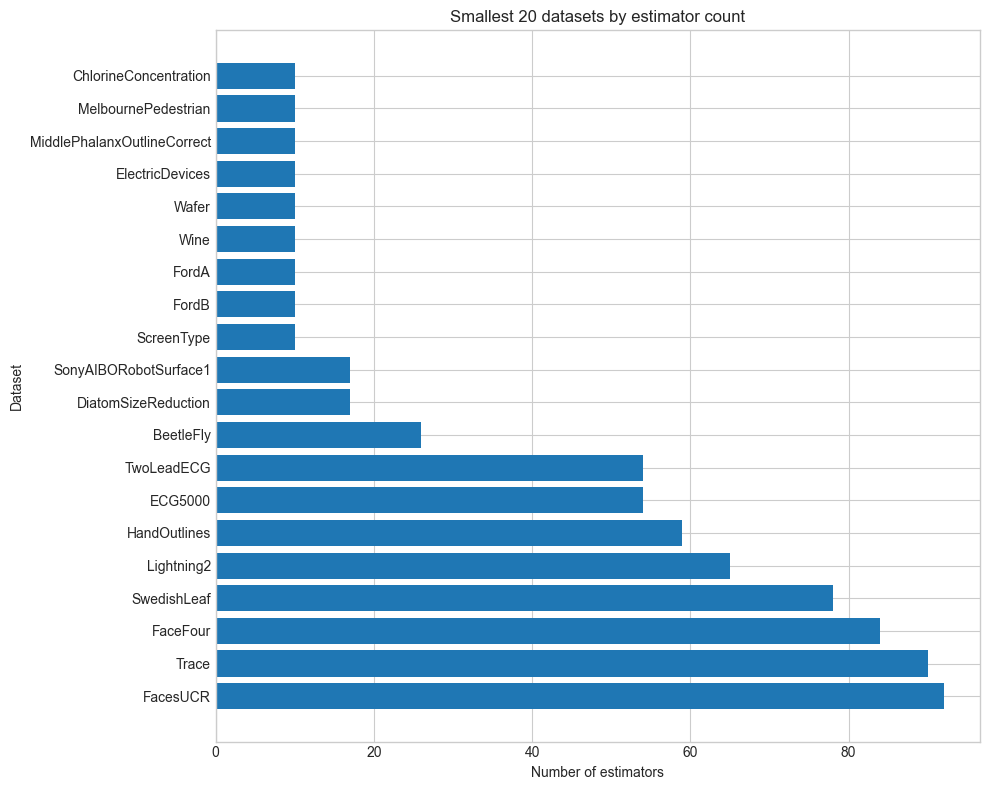

In [31]:
smallest_n = 20
least_complex = summary_df.head(smallest_n)
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(least_complex['dataset'], least_complex['n_estimators'], color='#1f77b4')
ax.set_xlabel('Number of estimators')
ax.set_ylabel('Dataset')
ax.set_title(f'Smallest {smallest_n} datasets by estimator count')
ax.invert_yaxis()
plt.tight_layout()
plt.show()


## Correlation Matrix: Metrics Relationships

A heatmap showing correlations between all metrics: EU complexity, forest statistics, and dataset characteristics. This reveals which factors most strongly influence model complexity.

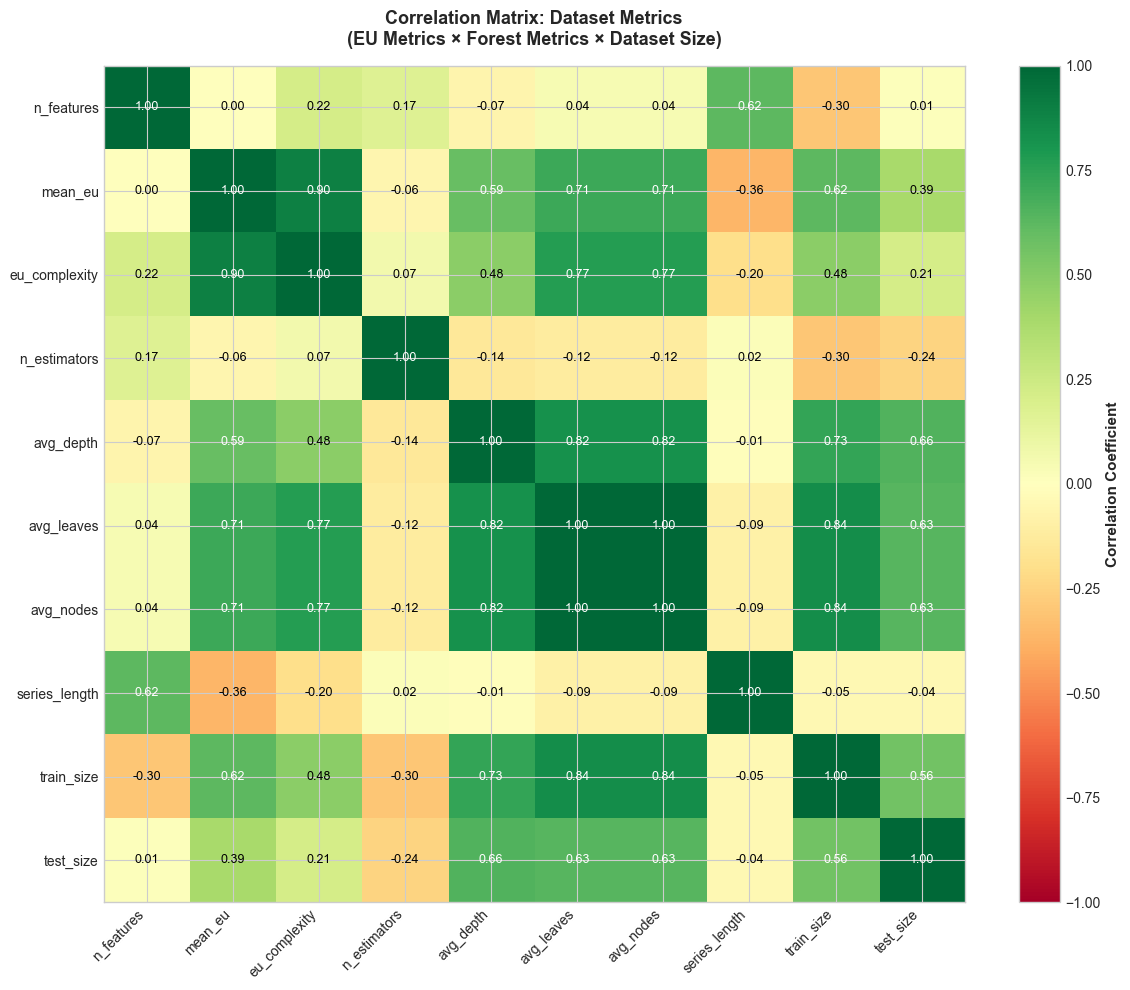


STRONGEST CORRELATIONS:

Top 10 Positive/Negative Correlations:
 1. avg_leaves           ↔ avg_nodes           : +1.000 ↑
 2. mean_eu              ↔ eu_complexity       : +0.898 ↑
 3. avg_leaves           ↔ train_size          : +0.842 ↑
 4. avg_nodes            ↔ train_size          : +0.842 ↑
 5. avg_depth            ↔ avg_nodes           : +0.820 ↑
 6. avg_depth            ↔ avg_leaves          : +0.820 ↑
 7. eu_complexity        ↔ avg_leaves          : +0.766 ↑
 8. eu_complexity        ↔ avg_nodes           : +0.766 ↑
 9. avg_depth            ↔ train_size          : +0.734 ↑
10. mean_eu              ↔ avg_leaves          : +0.711 ↑


In [32]:
# Prepare data for correlation analysis
corr_df = summary_df[[
    'n_features', 'mean_eu', 'eu_complexity',
    'n_estimators', 'avg_depth', 'avg_leaves', 'avg_nodes',
    'series_length', 'train_size', 'test_size'
]].copy()

# Calculate correlation matrix
corr_matrix = corr_df.corr()

# Create heatmap
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(corr_matrix, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)

# Set ticks and labels
ax.set_xticks(np.arange(len(corr_matrix.columns)))
ax.set_yticks(np.arange(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(corr_matrix.columns, fontsize=10)

# Add correlation values as text
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        value = corr_matrix.iloc[i, j]
        color = 'white' if abs(value) > 0.5 else 'black'
        text = ax.text(j, i, f'{value:.2f}',
                      ha='center', va='center', color=color, fontsize=9)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Correlation Coefficient', fontsize=11, fontweight='bold')

ax.set_title('Correlation Matrix: Dataset Metrics\n(EU Metrics × Forest Metrics × Dataset Size)', 
            fontsize=13, fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

# Print key correlations
print("\nSTRONGEST CORRELATIONS:")
print("=" * 60)

# Find strongest correlations (excluding diagonal)
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_pairs.append((
            corr_matrix.columns[i],
            corr_matrix.columns[j],
            corr_matrix.iloc[i, j]
        ))

# Sort by absolute correlation
corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

print("\nTop 10 Positive/Negative Correlations:")
for i, (var1, var2, corr) in enumerate(corr_pairs[:10], 1):
    direction = "↑" if corr > 0 else "↓"
    print(f"{i:2d}. {var1:20s} ↔ {var2:20s}: {corr:+.3f} {direction}")

## Distribution of estimator counts

Finally, a histogram shows how estimator usage varies across datasets.

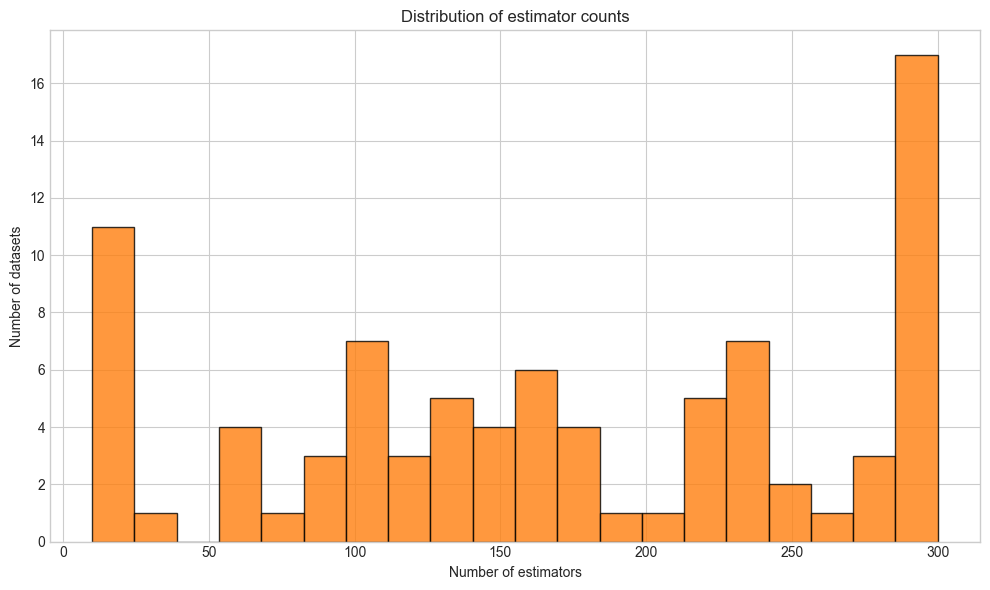

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(summary_df['n_estimators'], bins=20, color='#ff7f0e', edgecolor='black', alpha=0.8)
ax.set_xlabel('Number of estimators')
ax.set_ylabel('Number of datasets')
ax.set_title('Distribution of estimator counts')
plt.tight_layout()
plt.show()